In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def load_wine(split_ratio = 0.5):
    feat, label = load_wine()

    # normalization
    feat = np.pi * (feat - np.min(feat, axis=0, keepdims=True)) / np.ptp(feat, axis=0, keepdims=True)
    index_c0 = label == 0
    index_c1 = label == 1

    label = label * 2 - 1

    n_c0 = sum(index_c0)
    n_c1 = sum(index_c1)

    X_train = np.concatenate((feat[index_c0][:int(split_ratio*n_c0)], feat[index_c1][:int(split_ratio*n_c1)]), axis=0)
    y_train = np.concatenate((label[index_c0][:int(split_ratio*n_c0)], label[index_c1][:int(split_ratio*n_c1)]), axis=0)

    X_test = np.concatenate((feat[index_c0][int(split_ratio*n_c0):], feat[index_c1][int(split_ratio*n_c1):]), axis=0)
    y_test = np.concatenate((label[index_c0][int(split_ratio*n_c0):], label[index_c1][int(split_ratio*n_c1):]), axis=0)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_wine()

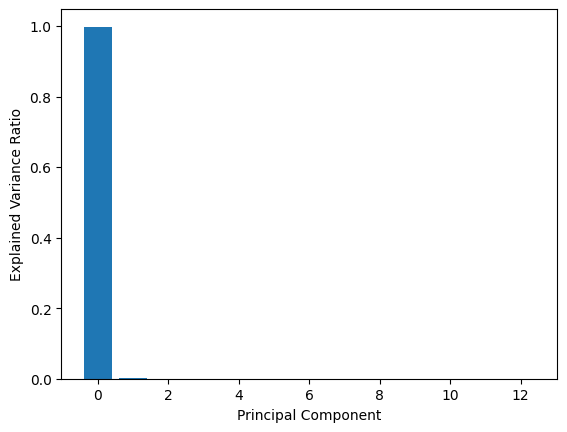

Number of components to retain 70% variance: 1


In [ ]:
#X = Normalizer().fit_transform(X)

pca = PCA()
pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.90) + 1 

print(f"Number of components to retain 70% variance: {n_components}")

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
def data_encoding(x):
    n_qubit = len(x)
    qml.AngleEmbedding(features = x, wires = range(n_qubit) , rotation = "X")
    for i in range(n_qubit):
        if i+1 < n_qubit:
            qml.CNOT(wires=[i, i+1])
        

In [50]:
def classifier(param, x=None):
    data_encoding(x)
    n_layer, n_qubit = param.shape[0], param.shape[1]
    for i in range(n_layer):
        for j in range(n_qubit):
            qml.Rot(param[i, j, 0], param[i, j, 1], param[i, j, 2], wires=j)
        for j in range(n_qubit):
            if j+1 < n_qubit:
                qml.CNOT(wires=[j, j+1])

    return qml.expval(qml.PauliZ(0))

In [51]:
n_qubit = X_train.shape[1]
dev = qml.device('default.qubit', wires=n_qubit)
circuit = qml.QNode(classifier, dev)

In [52]:
def mse_loss(predict, label):
    return np.mean((predict - label)**2)

def cost(param, circuit, X, y):
    exp = []
    for i in range(len(X)):
        pred = circuit(param, x=X[i])
        exp.append(pred)

    return mse_loss(np.array(exp), y)

def accuracy(predicts, labels):
    assert len(predicts) == len(labels)
    return np.sum((np.sign(predicts)*labels+1)/2)/len(predicts)

In [ ]:
lr = 0.01
opt = AdamOptimizer(lr)
batch_size = 4

n_epoch = 50
cost_train, cost_test, acc_train, acc_test = [], [], [], []

param = np.random.rand(2, n_qubit, 3)
param = param*2*np.pi

for i in range(n_epoch):
    index = np.random.permutation(len(X_train))
    feat_train, label_train = X_train[index], y_train[index]

    for j in range(0, len(X_train), batch_size):
        feat_train_batch = feat_train[j*batch_size:(j+1)*batch_size]
        label_train_batch = label_train[j*batch_size:(j+1)*batch_size]

        param = opt.step(lambda v: cost(v, circuit, feat_train_batch, label_train_batch), param)

    cost_train.append(cost(param, circuit, X_train, y_train))
    cost_test.append(cost(param, circuit, X_test, y_test))

    pred_train = []
    for j in range(len(X_train)):
        pred_train.append(circuit(param, x=X_train[j]))

    acc_train.append(accuracy(np.array(pred_train), y_train))

    pred_test = []
    for j in range(len(X_test)):
        pred_test.append(circuit(param, x=X_test[j]))
        
    acc_test.append(accuracy(np.array(pred_test), y_test))

    print(f'Epoch {i+1}/{n_epoch} : Train cost = {cost_train[-1]}, Test cost = {cost_test[-1]}, Train accuracy = {acc_train[-1]}, Test accuracy = {acc_test[-1]}')

Epoch 1/50 : Train cost = 2.0710780773029307, Test cost = 2.041169879302015, Train accuracy = 0.1443661971830986, Test accuracy = 0.2222222222222222
Epoch 2/50 : Train cost = 2.0710780773029307, Test cost = 2.041169879302015, Train accuracy = 0.1443661971830986, Test accuracy = 0.2222222222222222
Epoch 3/50 : Train cost = 2.0710780773029307, Test cost = 2.041169879302015, Train accuracy = 0.1443661971830986, Test accuracy = 0.2222222222222222


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
epochs = np.arange(n_epoch) + 1
plt.plot(epochs, cost_train, label='Training Cost',
marker='o')
plt.plot(epochs, cost_test, label='Test Cost', marker='o')
plt.title('Cost Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.grid()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train, label='Training Accuracy',
marker='o')
plt.plot(epochs, acc_test, label='Test Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()